In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import truncnorm, gamma, norm, cosine, invgamma, gennorm
import scipy.special as sc
import torch

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [27]:
#read in the raw data from just 2023 so that we know that there are no shifts
from google.colab import drive
drive.mount('/drive')

raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [28]:
#we only want balls in play with non-null measurements
all_data = raw23
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) <= 45]

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

all_data['outcome'] = -1
all_data.loc[all_data.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 'sac_bunt',
                                               'sac_fly_double_play']), 'outcome'] = 0 # in play out
all_data.loc[all_data.events == 'single', 'outcome'] = 1 #single
all_data.loc[all_data.events == 'double', 'outcome'] = 2 # double
all_data.loc[all_data.events == 'triple', 'outcome'] = 3 #triple
all_data.loc[all_data.events == 'home_run', 'outcome'] = 4 #hr

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'launch_speed', 'launch_angle', 'on_3b', 'on_2b', 'on_1b', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'la_type', 'is_gb','is_ld', 'is_fb', 'is_pu', 'outcome', 'events']]

#we only need groundballs
df = all_data.loc[all_data.is_gb == 1]

<ipython-input-28-4464e89b1160>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['la_type'] = 0 #gb
<ipython-input-28-4464e89b1160>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['is_gb'] = 0
<ipython-input-28-4464e89b1160>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [29]:
#infield alignment Using this link: https://baseballsavant.mlb.com/visuals/fielder-positioning?teamId=&firstBase=0&shift=0&batSide=L&season=2023&position=&attempts=10
#I can get the average angles and depths for each of those positioning types in 2023

#initialize infielder depths and angles
df[['a3', 'a4','a5','a6', 'd3','d4','d5','d6']]= np.array([34, 12, -32,-13,111,148,119,147])

#I literally eyeballed these and guessed :( I used the situation where there were no baserunners, so remove plays with baserunners
df = df.loc[(np.isnan(df.on_3b)) & (np.isnan(df.on_2b)) & (np.isnan(df.on_1b))]
df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6']] = np.array([42, 20, -22.5, -5, 126, 147, 132, 152])
df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6']] = np.array([42, 20, -27, -7.5, 124, 148, 117, 152])

df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6']] = np.array([28, 5, -42.5, -20, 116, 154, 125, 145])
df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6']] = np.array([30, 7.5, -42.5, -20, 116, 153, 118, 148])

#calculate angular distance
df['ad3'] = df.a3.values - df.hit_direction.values
df['ad4'] = df.a4.values - df.hit_direction.values
df['ad5'] = df.a5.values - df.hit_direction.values
df['ad6'] = df.a6.values - df.hit_direction.values

<ipython-input-29-b25428500360>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['a3', 'a4','a5','a6', 'd3','d4','d5','d6']]= np.array([34, 12, -32,-13,111,148,119,147])
<ipython-input-29-b25428500360>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['a3', 'a4','a5','a6', 'd3','d4','d5','d6']]= np.array([34, 12, -32,-13,111,148,119,147])
<ipython-input-29-b25428500360>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [30]:
#get the closest infielder by angle, their angle, and their depth. We're going to ignore the catcher and pitcher because obviously their positions are fixed
df['closest_infielder'] = np.argmin(np.abs(df[['ad3', 'ad4', 'ad5', 'ad6']].values),axis=1)  + 3
#get the corresponding coordinates for that infielder, and depth, and angle.
df['closest_infielder_angle'] = np.nan
df['closest_infielder_depth'] = np.nan
df['closest_infielder_angle_diff'] = np.nan
for i in range(3,7):
    df.loc[df.closest_infielder == i, ['closest_infielder_angle', 'closest_infielder_depth', 'closest_infielder_angle_diff']] = df.loc[df.closest_infielder == i, ['a' + str(i), 'd' + str(i), 'ad' + str(i)]].values

<ipython-input-30-9a79bb5a1b1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['closest_infielder'] = np.argmin(np.abs(df[['ad3', 'ad4', 'ad5', 'ad6']].values),axis=1)  + 3
<ipython-input-30-9a79bb5a1b1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['closest_infielder_angle'] = np.nan
<ipython-input-30-9a79bb5a1b1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [31]:
df['is_out'] = 0
df.loc[df.outcome == 0, 'is_out'] = 1

<ipython-input-31-8564507534ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_out'] = 0


In [32]:
#remove possibly odd positionings
df=df.loc[df.if_fielding_alignment != 'Infield shift']
df = df.loc[df.if_fielding_alignment != 'Strategic']

### Model

In [33]:
#calibration
def eda_calibration(preds, actuals, groupsize = 1000, use_log_odds = True, title = '', xlab = '', ylab = ''):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    if use_log_odds:
        actual = np.array(actual)
        plt.plot(predicted, np.log(actual / (1-actual)), 'k.')
    else:
        plt.plot(predicted, actual, 'k.')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

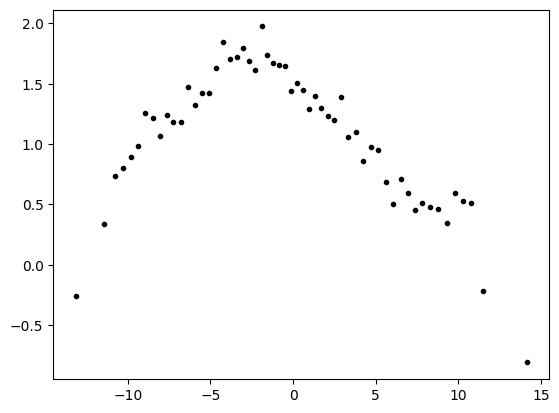

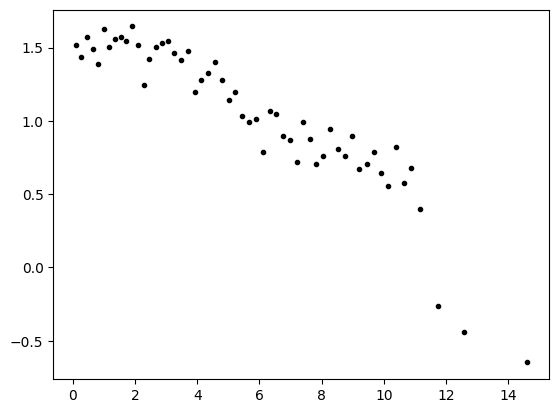

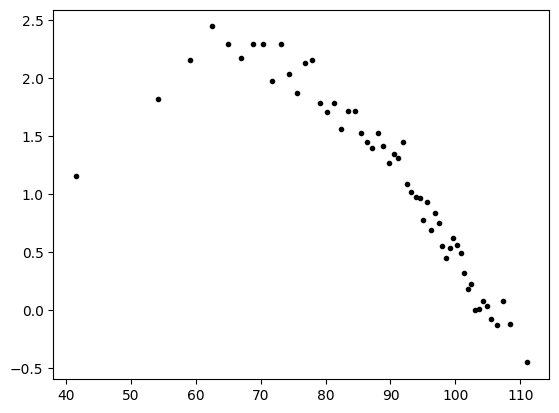

In [34]:
eda_calibration(df.closest_infielder_angle_diff.values, df.is_out.values, 500)
plt.show()

eda_calibration(np.abs(df.closest_infielder_angle_diff.values), df.is_out.values, 500)
plt.show()

eda_calibration(df.launch_speed.values, df.is_out.values, 500)
plt.show()

Definitely some linear-ish relationships with absolute angle diff

In [35]:
df['abs_angle_diff'] = np.abs(df.closest_infielder_angle_diff.values)

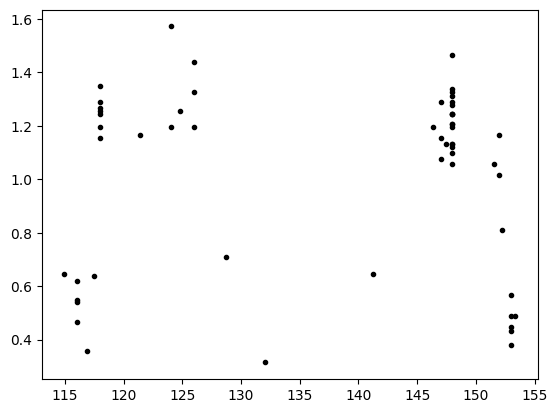

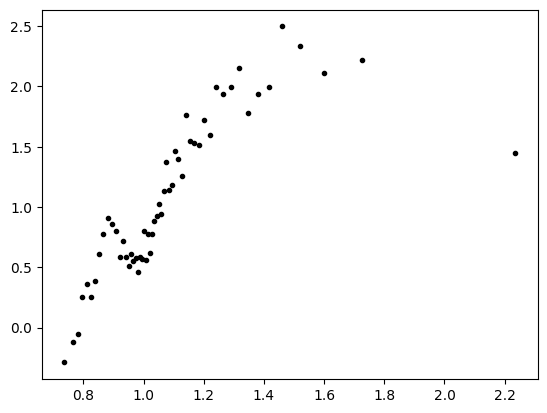

In [36]:
#ball time to fielder
eda_calibration(df.closest_infielder_depth.values, df.is_out.values, 500)
plt.show()
eda_calibration(df.closest_infielder_depth.values / (df.launch_speed.values * 1.4667), df.is_out.values, 500)
plt.show()

Ball time to fielder, which is a measurement of how how ball speed and fielder depth interact with each other, looks to have some relationship with outs.

In [37]:
df['bttf'] = df.closest_infielder_depth.values / (df.launch_speed.values * 1.4667)

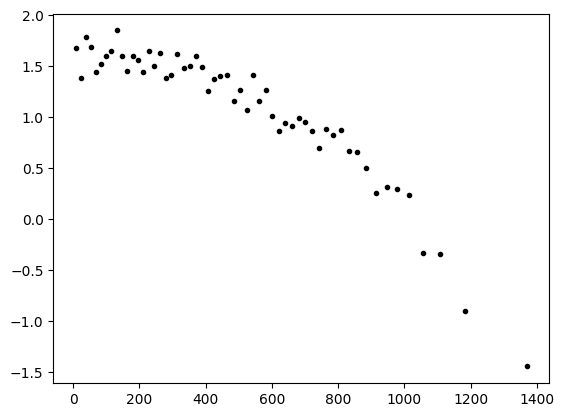

In [38]:
#interaction between ev and angle
eda_calibration(df.launch_speed.values * df.abs_angle_diff.values, df.is_out.values, 500)
plt.show()

In [39]:
df['ev_angle_inter'] = df.launch_speed.values * df.abs_angle_diff.values

### Cross validation and feature selection

In [40]:
def cross_val_func(features, iterations = 100, plot_iter = 25):

    train_acs = []
    train_f1=[]
    accs = []
    f1 = []
    for i in range(iterations):
        train, test = train_test_split(df, test_size = 0.3)
        mod = LogisticRegression().fit(train[features].values, train.is_out.values)
        preds = mod.predict(test[features].values)
        acc = np.mean(preds == test.is_out.values)
        accs.append(acc)
        f1.append(f1_score(test.is_out.values, preds))
        preds2 = mod.predict(train[features].values)
        acc2 = np.mean(preds2 == train.is_out.values)
        train_acs.append(acc2)
        train_f1.append(f1_score(train.is_out.values, preds2))

        if i%plot_iter == 0:
            probs = mod.predict_proba(test[features].values)[:,1]
            calibration(probs, test.is_out.values, 200)
            plt.show()

    plt.hist(train_acs, density = True)
    plt.title('Train Set Accuracy')
    plt.show()
    plt.hist(accs, density = True)
    plt.title('Test Set Accuracy')
    plt.show()
    plt.hist(train_f1, density = True)
    plt.title('Train Set F1')
    plt.show()
    plt.hist(f1, density = True)
    plt.title('Test Set F1')
    plt.show()

    print('train mean accuracy: ' + str(np.mean(train_acs)) + ', test mean accuracy: ' + str(np.mean(accs)) + ', train mean f1: ' + str(np.mean(train_f1)) +  ', test mean f1: ' + str(np.mean(f1)))

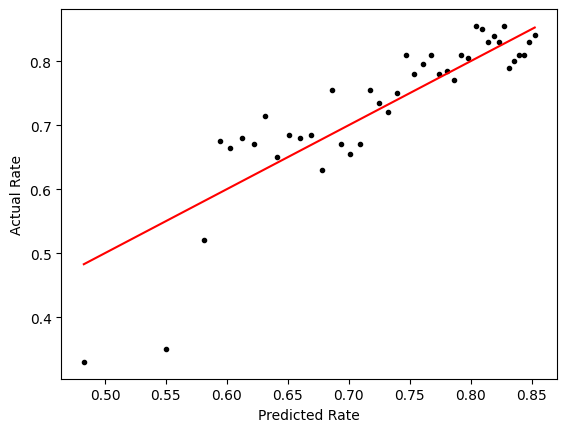

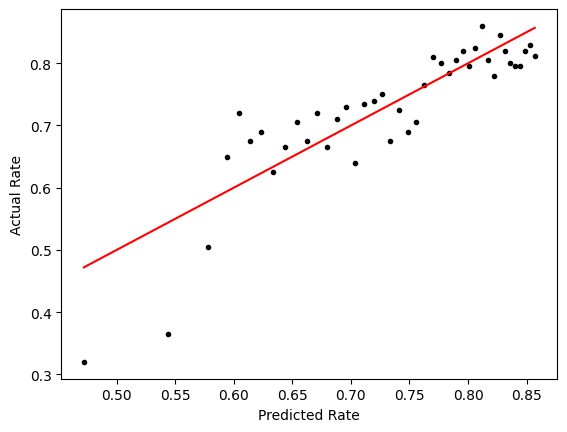

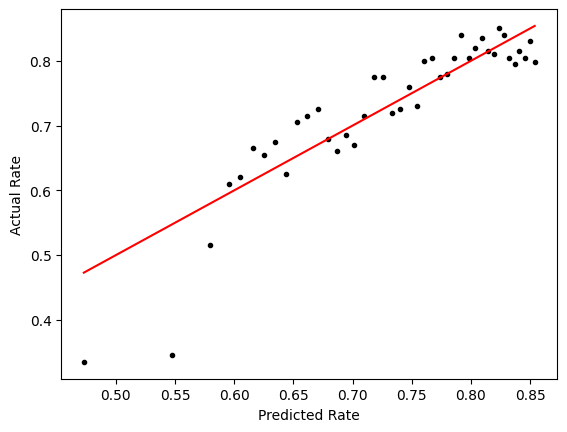

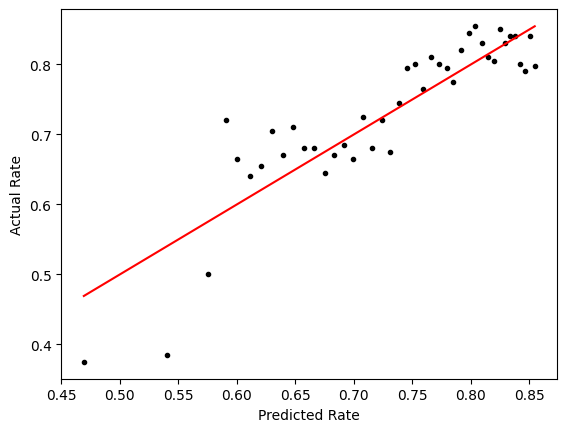

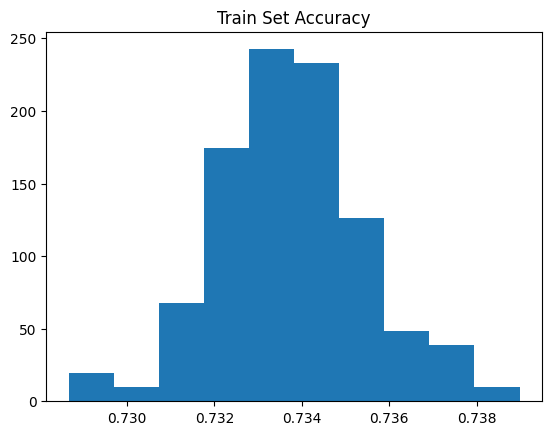

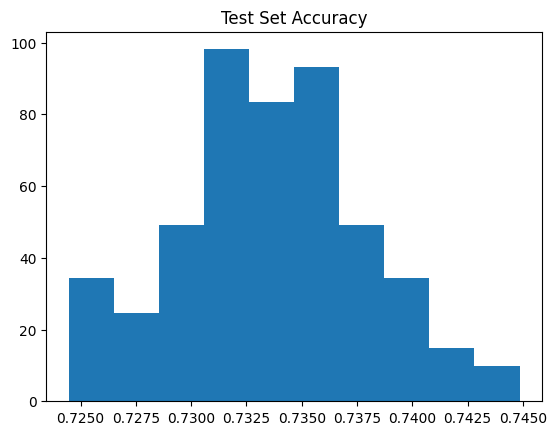

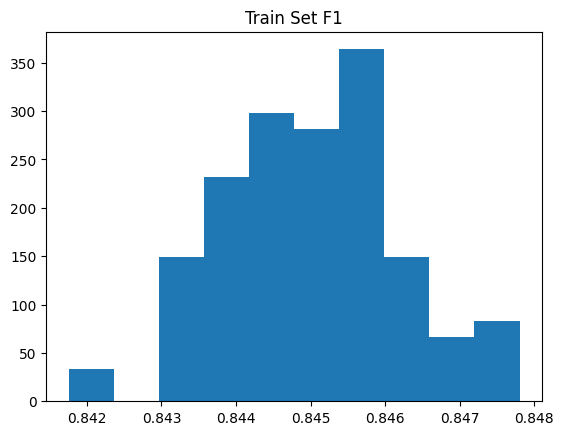

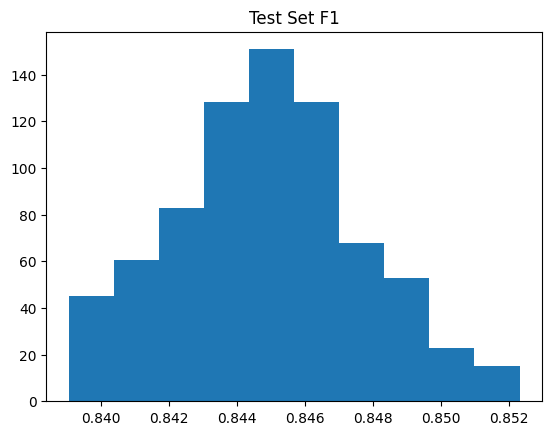

train mean accuracy: 0.7337672694026819, test mean accuracy: 0.7335660109030576, train mean f1: 0.8450170871311777, test mean f1: 0.8448729559564089


In [41]:
#start with the simplest feature that we know matters, angle diff
cross_val_func(['abs_angle_diff'])

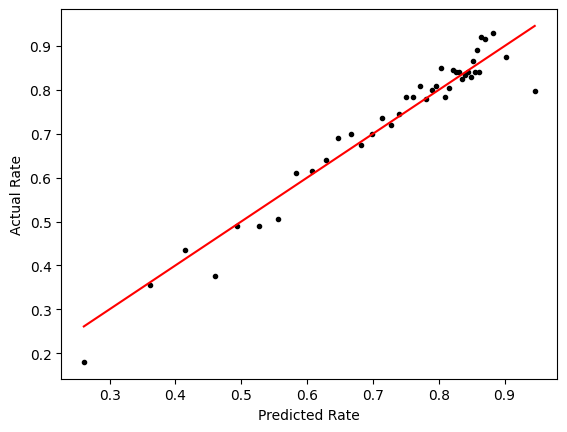

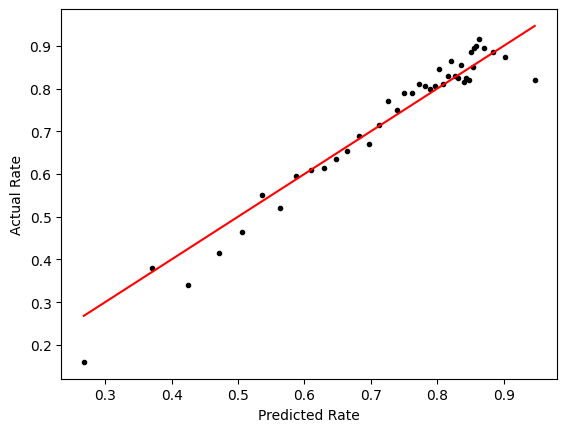

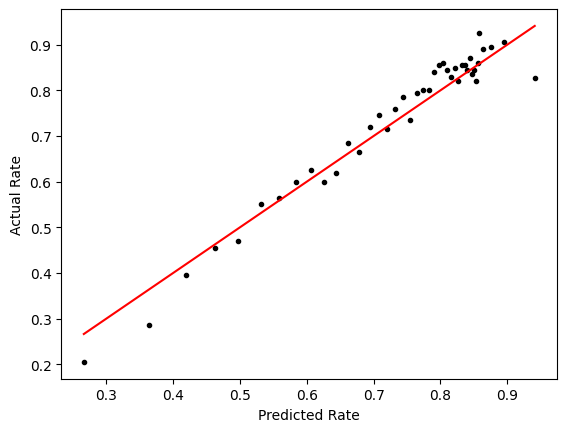

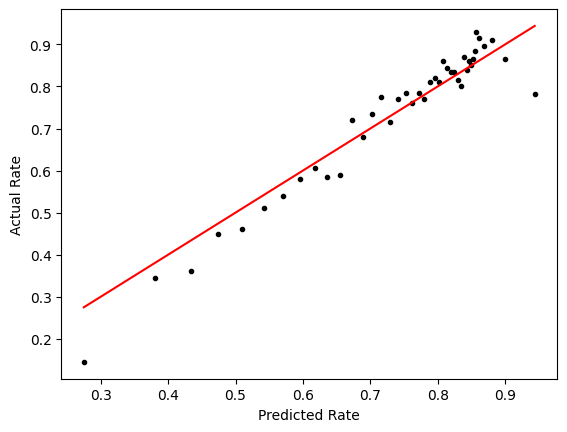

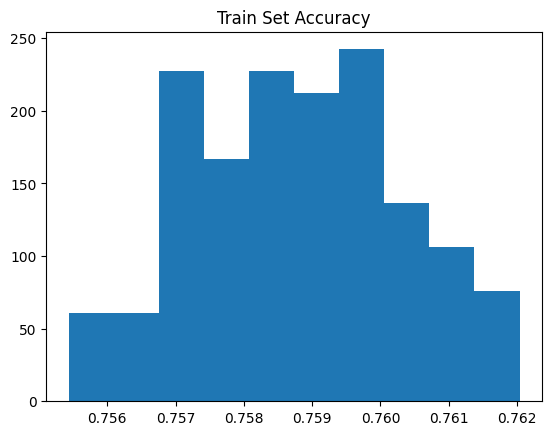

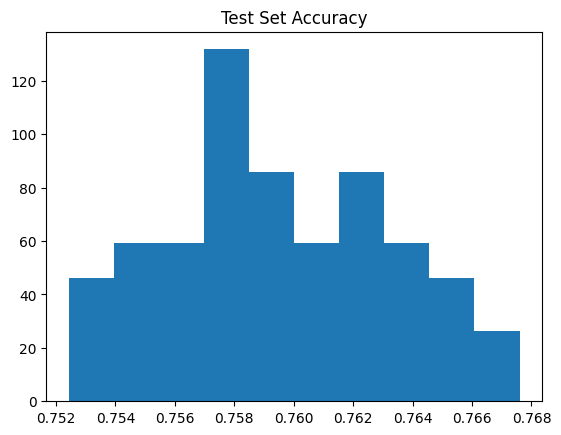

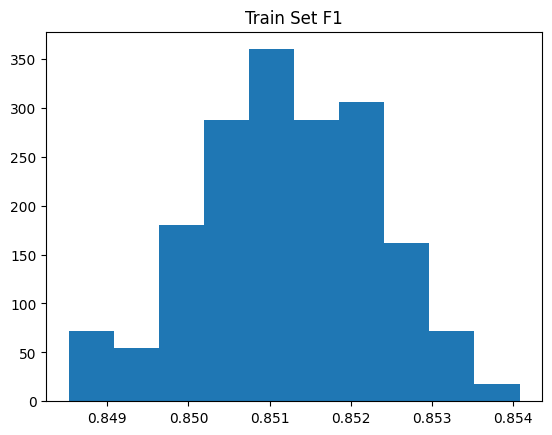

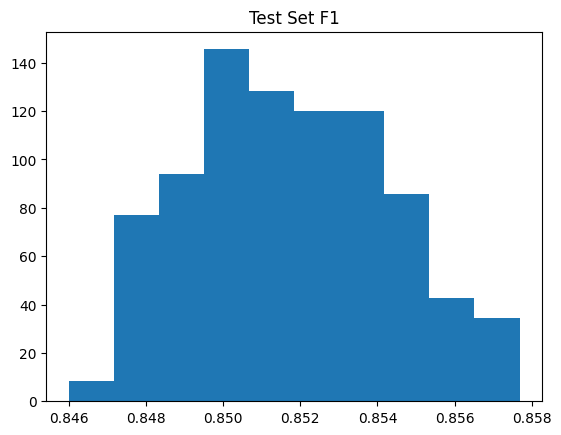

train mean accuracy: 0.7587606663957742, test mean accuracy: 0.7595046219483289, train mean f1: 0.8512148017701621, test mean f1: 0.8517879314548967


In [42]:
cross_val_func(['abs_angle_diff', 'ev_angle_inter'])

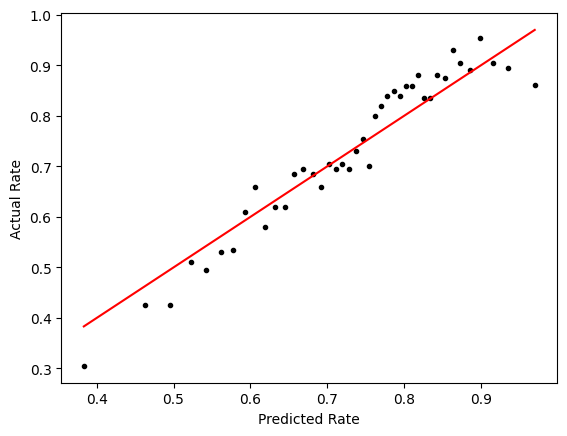

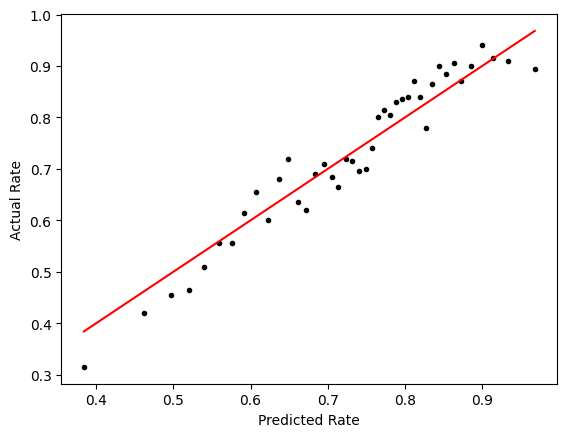

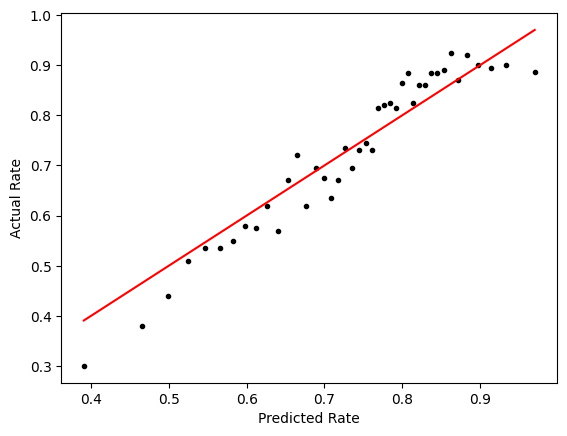

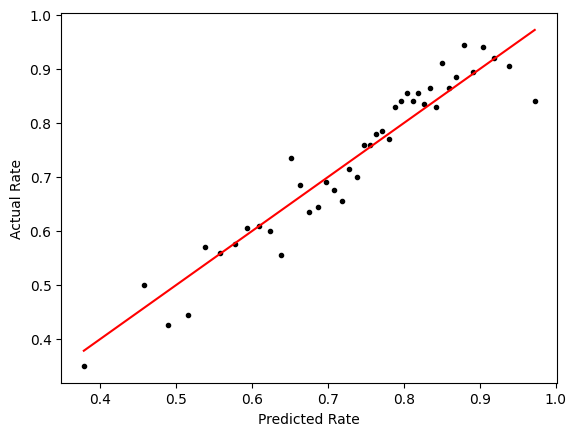

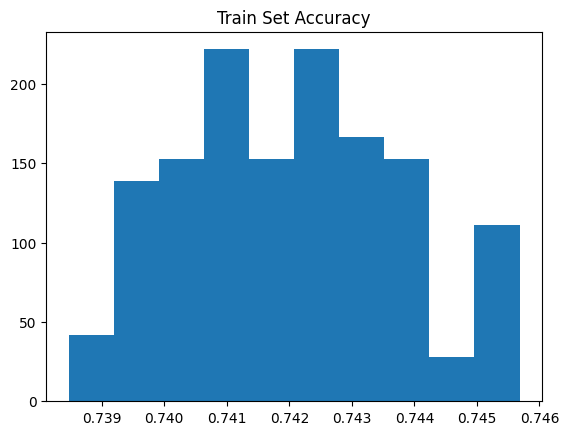

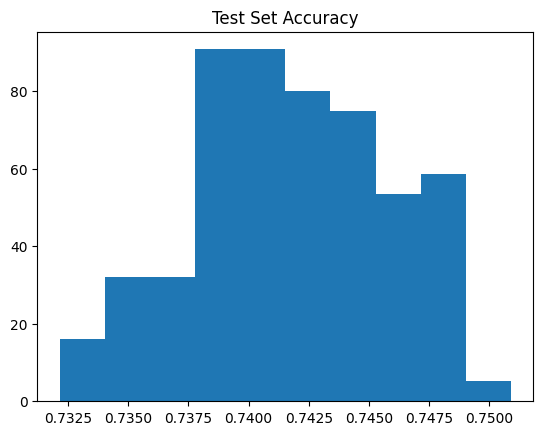

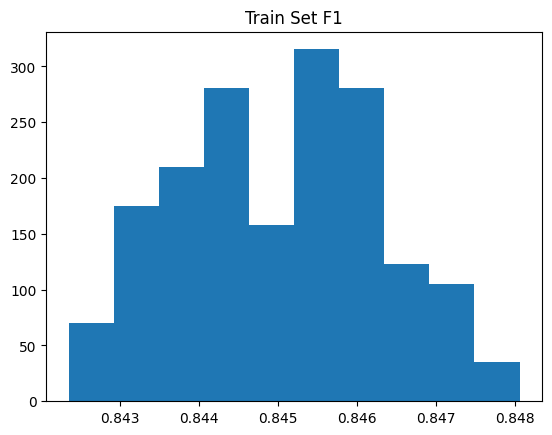

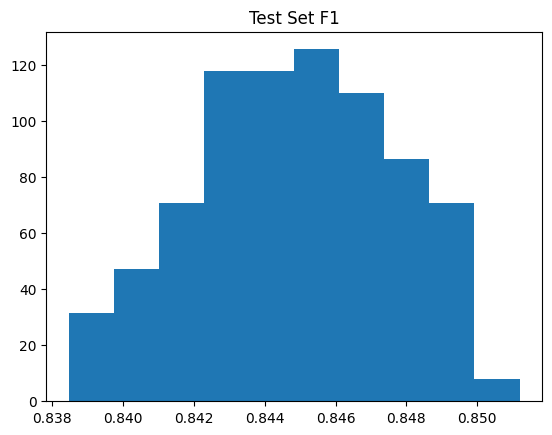

train mean accuracy: 0.7420022348638764, test mean accuracy: 0.7417693766295329, train mean f1: 0.8450212466069627, test mean f1: 0.8447920475071709


In [43]:
#ball time to fielder and absolute angle
features = ['abs_angle_diff', 'bttf']
cross_val_func(features)

ball time to fielder didn't significantly help with train/test accuracy or F1, but it definitely seems to help with calibration.

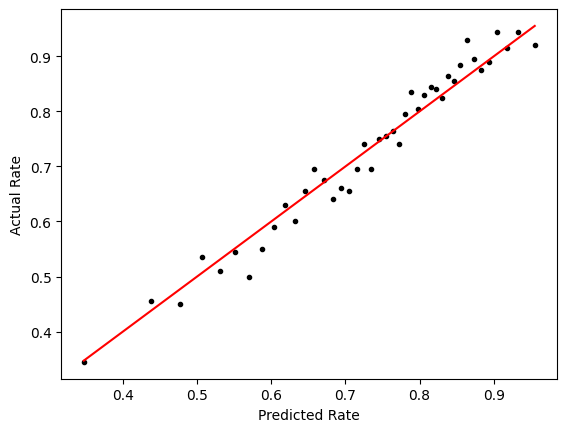

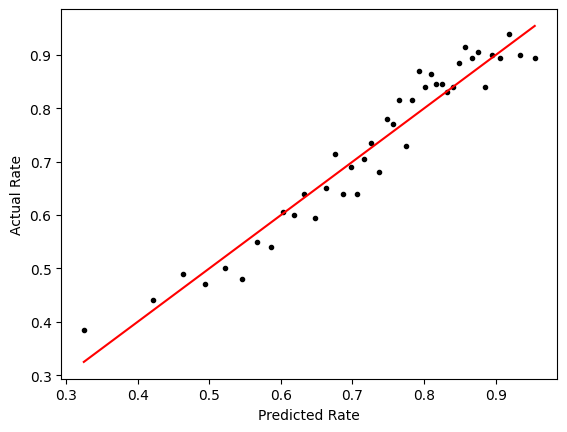

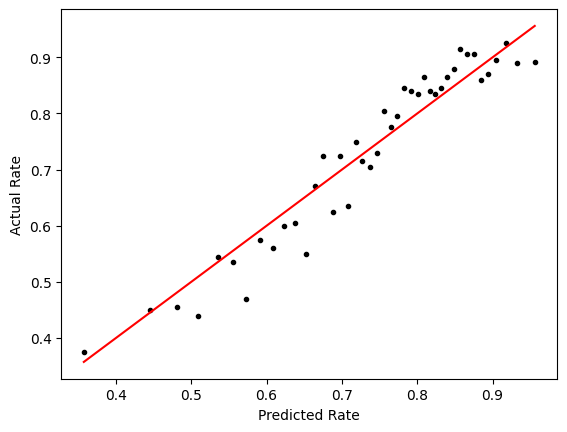

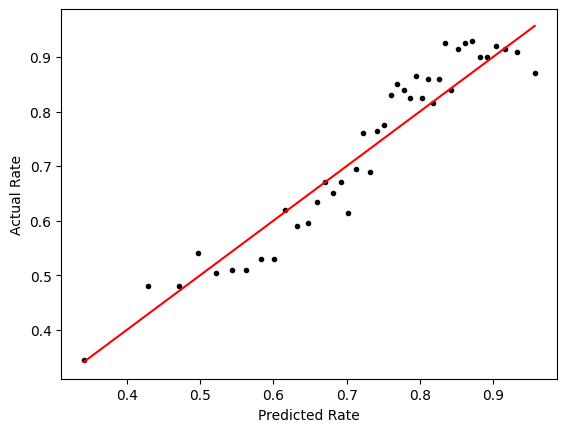

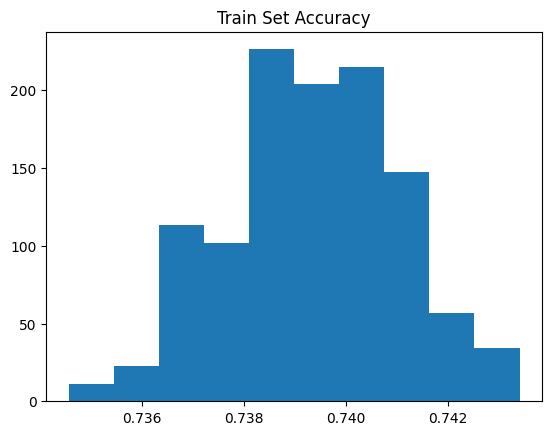

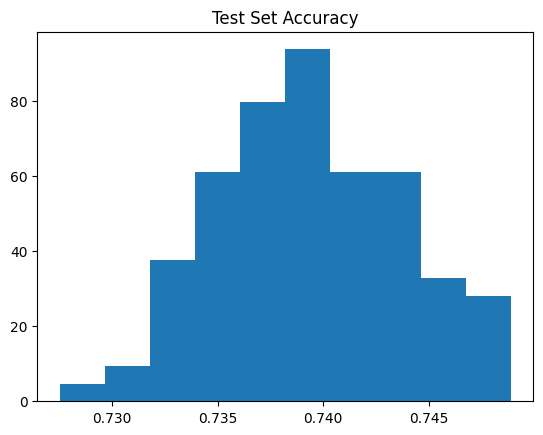

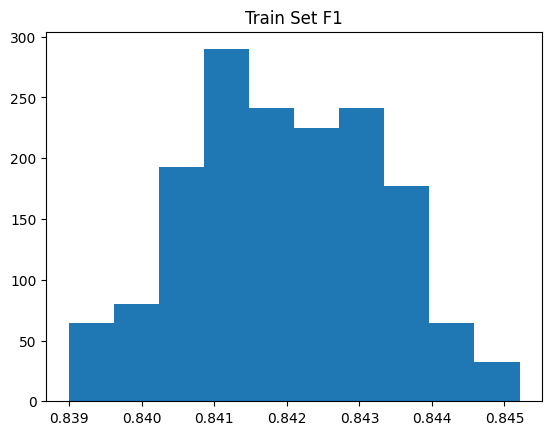

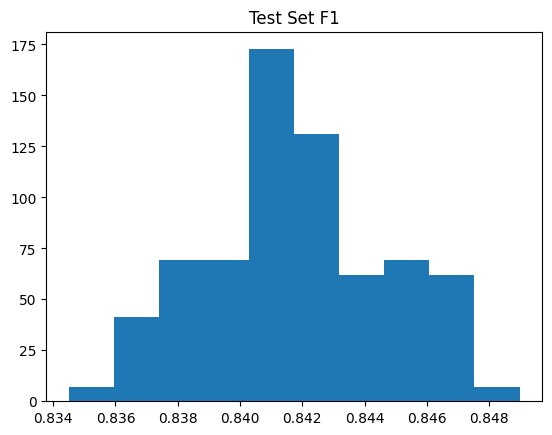

train mean accuracy: 0.7393559528646891, test mean accuracy: 0.7392581180374495, train mean f1: 0.8419614361005041, test mean f1: 0.8418532777804311


In [44]:
#ball time to fielder (second degree) and absolute angle
df['bttf2'] = df.bttf.values**2
features = ['abs_angle_diff', 'bttf', 'bttf2']
cross_val_func(features)

Adding bttf squared once again didn't help accuracy or f1 significantly, but I like the calibration plots better at the upper end.

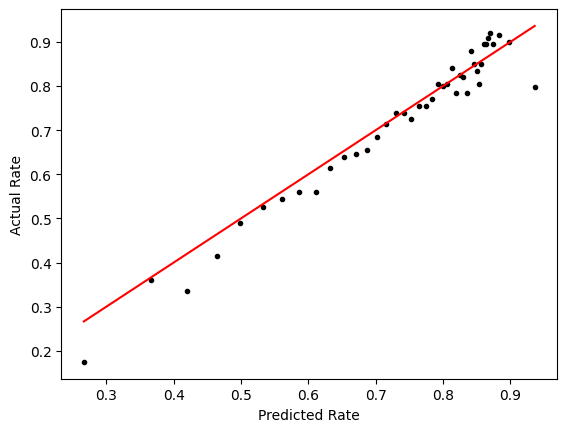

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


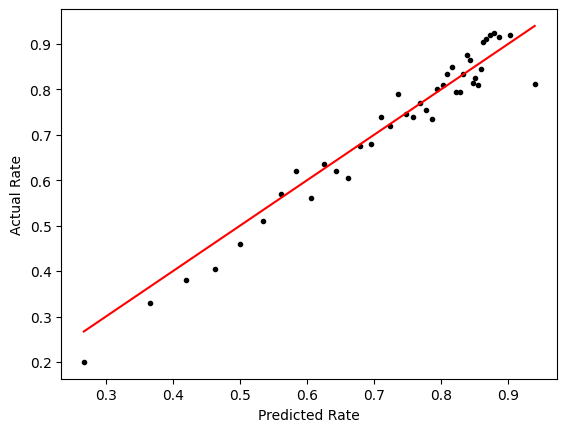

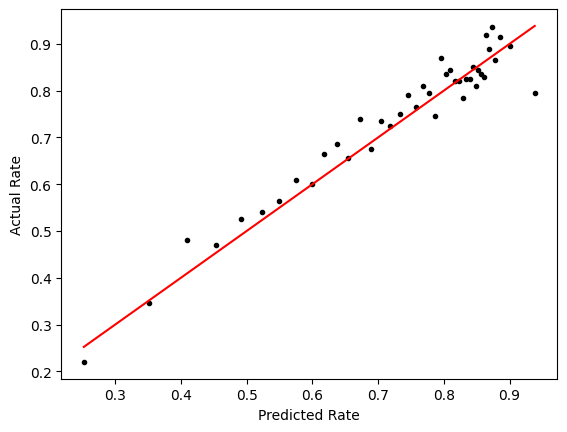

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

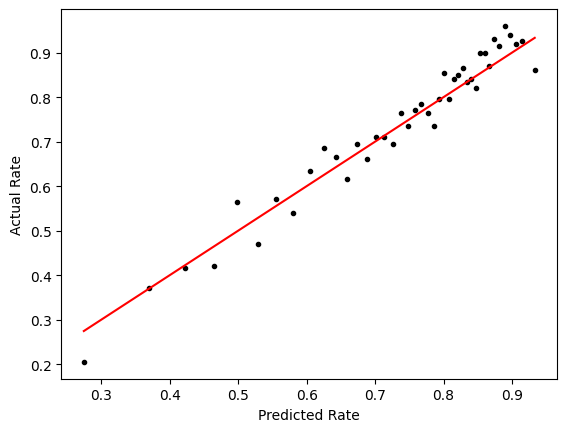

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


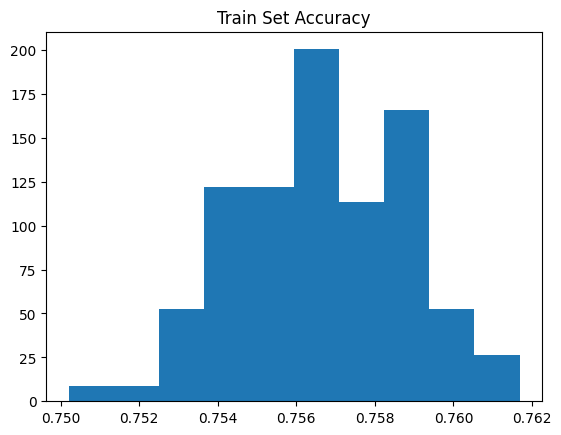

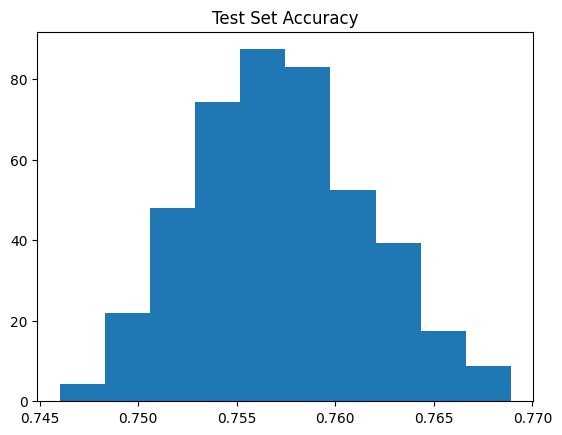

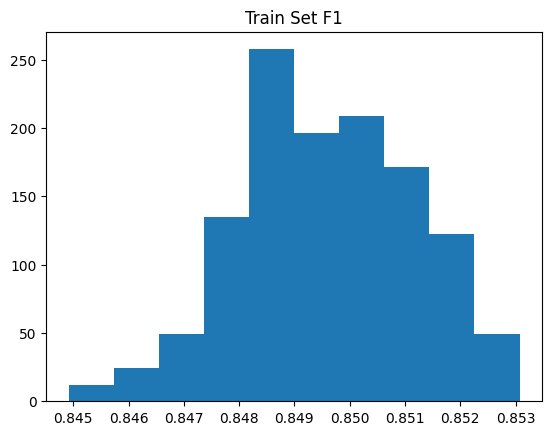

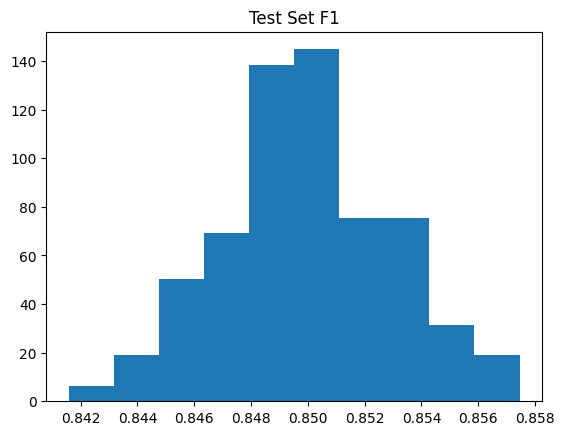

train mean accuracy: 0.7566253555465257, test mean accuracy: 0.7570798767480444, train mean f1: 0.8496115735768065, test mean f1: 0.8499077647155409


In [45]:
#try adding the ev angle interaction
df['ev_angle_inter'] = df.launch_speed.values * df.abs_angle_diff.values
features = ['abs_angle_diff', 'ev_angle_inter', 'bttf', 'bttf2']
cross_val_func(features)

Adding the ev angle interaction helped with accuracy and f1, but we ended up with some convergence issues. I have also found that it doesn't work well on low exit speed balls. The interaction with angle ends up having balls with exit speeds less than 60 as having positive slope with angle diff, meaning more angle diff is better. That should never be the case, and it ends up causing problems when we try to optimize for bunts, so I'm going to leave the ev angle interaction out.

### Coefficients

In [46]:
train,test = train_test_split(df, test_size = 0.3)

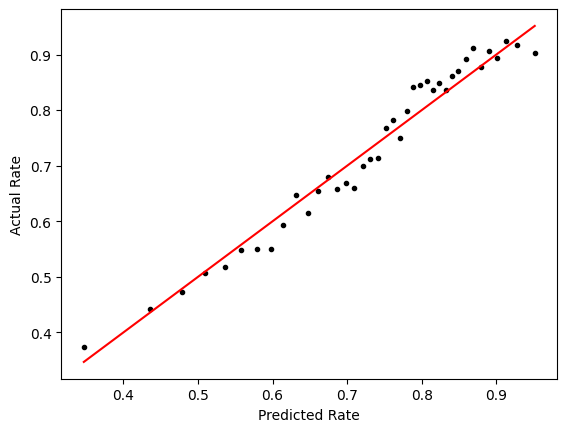

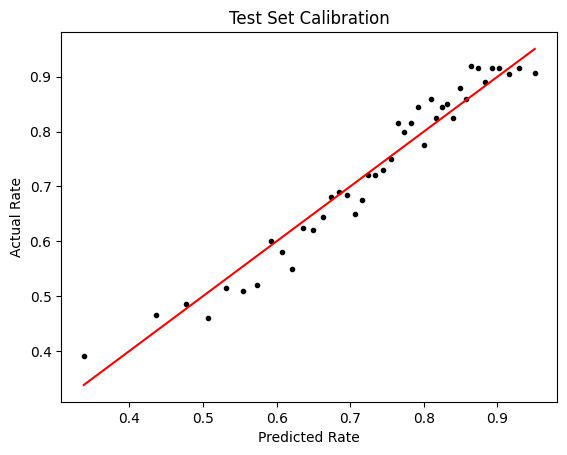

(array([[-0.14525461,  5.91221526, -1.35258613]]), array([-2.79461331]))

In [47]:
features = ['abs_angle_diff', 'bttf', 'bttf2']
mod = LogisticRegression().fit(train[features].values, train.is_out.values)
tpre = mod.predict_proba(train[features].values)
tepre = mod.predict_proba(test[features].values)
calibration(tpre[:,1], train.is_out.values, 500)
plt.show()
calibration(tepre[:,1], test.is_out.values, 200)
plt.title('Test Set Calibration')
plt.show()
mod.coef_, mod.intercept_

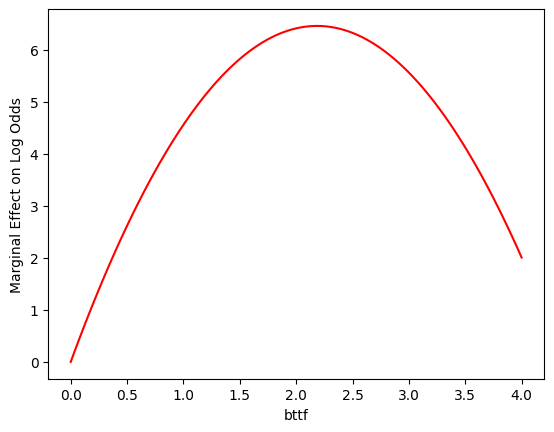

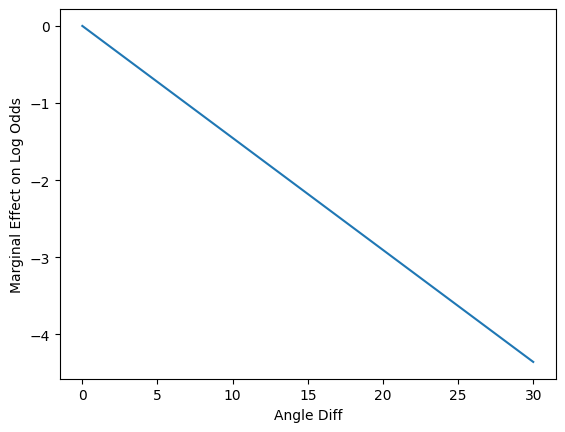

In [48]:
#plot marginal effects
x = np.linspace(0,4, 100)
plt.plot(x, 5.91221526*x -1.35258613*x**2, 'r-')
plt.xlabel('bttf')
plt.ylabel('Marginal Effect on Log Odds')
plt.show()

a = np.linspace(0, 30, 100)
plt.plot(a, -0.14525461 * a, '-')
plt.xlabel('Angle Diff')
plt.ylabel('Marginal Effect on Log Odds')
plt.show()

Based on the marginal effects plots, what does this model incentivize? For hard hit balls with low bttf, we are incentivized to increase our bttf by moving deeper. That makes sense. For slow balls with high bttf, we are incentivized to reduce bttf by moving closer. That makes sense. We are also always incentivized to reduce the angle diff, which makes sense.

In [49]:
features = ['abs_angle_diff', 'bttf', 'bttf2']
mod = LogisticRegression().fit(df[features].values, df.is_out.values)

In [50]:
mod.intercept_, mod.coef_

(array([-2.7808253]), array([[-0.1463456 ,  5.86696302, -1.31835977]]))

In [51]:
#manual predictions
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977
logodds = gb_int + gb_angle_diff * df.abs_angle_diff.values + gb_bttf * df.bttf.values + gb_bttf2 * df.bttf2.values
probits = torch.special.expit(torch.tensor(logodds, dtype = torch.float32)).numpy()

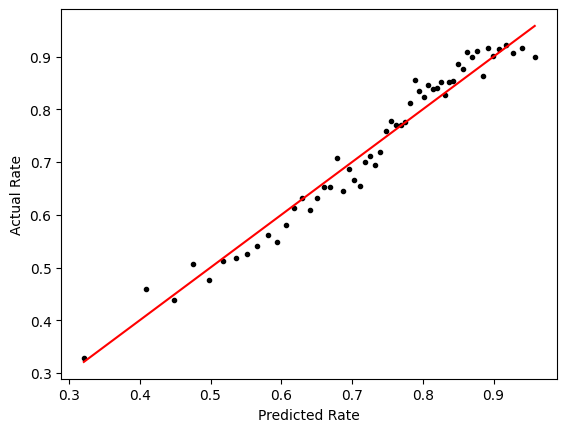

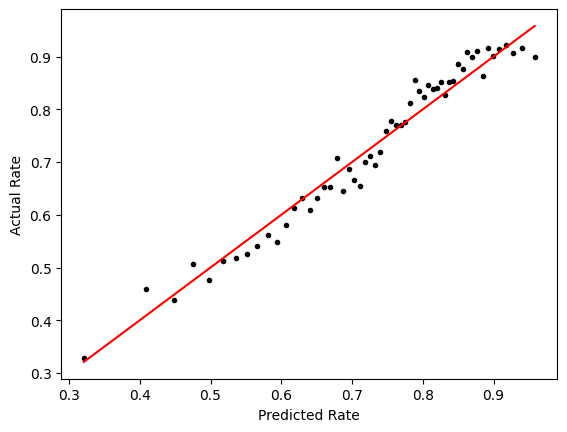

In [52]:
calibration(probits, df.is_out.values, 500)
plt.show()
p = mod.predict_proba(df[features].values)[:,1]
calibration(p, df.is_out.values, 500)
plt.show()

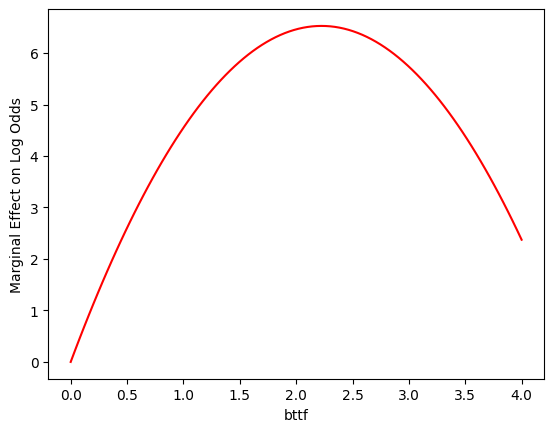

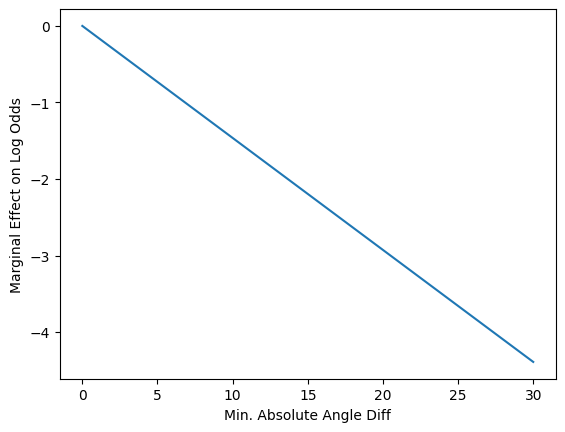

In [2]:
#plot marginal effects using the final model coefficients
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

x = np.linspace(0,4, 100)
plt.plot(x, gb_bttf*x + gb_bttf2*x**2, 'r-')
plt.xlabel('bttf')
plt.ylabel('Marginal Effect on Log Odds')
plt.show()

a = np.linspace(0, 30, 100)
plt.plot(a, gb_angle_diff * a, '-')
plt.xlabel('Min. Absolute Angle Diff')
plt.ylabel('Marginal Effect on Log Odds')
plt.show()

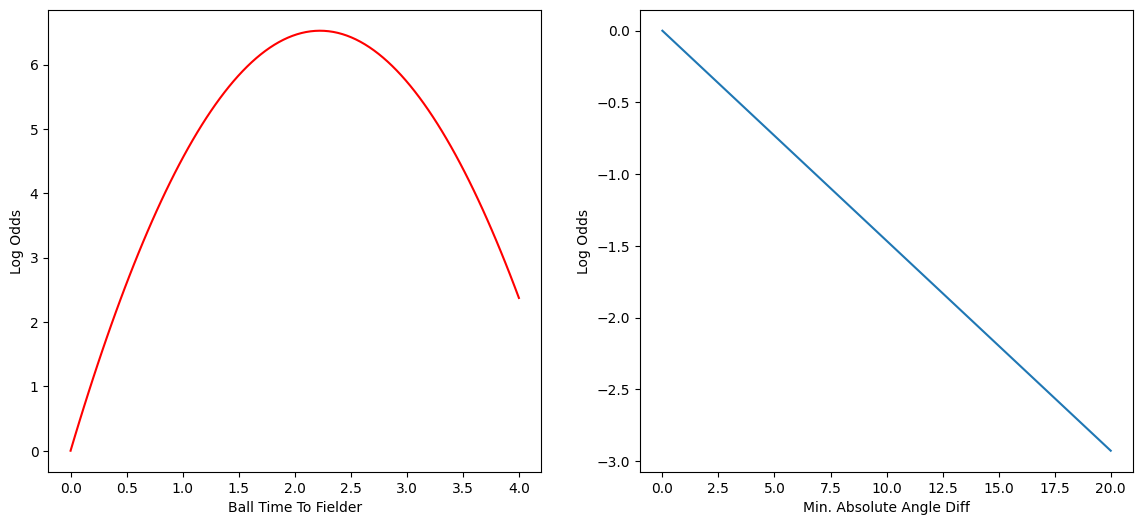

In [3]:
x = np.linspace(0,4, 100)
plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.plot(x, gb_bttf*x + gb_bttf2*x**2, 'r-')
ax1.set_xlabel('Ball Time To Fielder')
ax1.set_ylabel('Log Odds')

a = np.linspace(0, 20, 100)
ax2 = plt.subplot(122)
ax2.plot(a, gb_angle_diff * a, '-')
ax2.set_xlabel('Min. Absolute Angle Diff')
ax2.set_ylabel('Log Odds')
plt.show()